# 🔍 1. Introduction & Objective <a name="introduction"></a>

In this notebook, we will explore how various personality and behavior traits can predict whether a person is an Introvert or Extrovert. Using the July 2025 Kaggle Playground dataset, we'll create, test, and evaluate several machine learning models with the goal of developing a high-performing classifier.


In [1]:
from IPython.display import display, HTML

display(HTML("""
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ABUALHUSSEIN/introverts-extroverts-competition-Kaggle/refs/heads/main/dataanalystanwa.png" width="1000">
</div>
"""))


# 📦 Required Libraries

In [2]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 📚 Basic Libraries
import numpy as np
import pandas as pd

# 📊 2. Data Exploration (EDA) <a name="eda"></a>

In [19]:
# ⚙️ Settings
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 📁 Load Data
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")

# 🔍 Preview
train.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [6]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (18524, 9)
Test shape: (6175, 8)


The  train dataset has 18524 rows and 9 columns (8 features + 1 target).

In [7]:
column_names = train.columns.tolist()
print(column_names)

['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency', 'Personality']


## 📖 Feature Dictionary

The dataset contains various features representing behavioral and personality-related traits. Here’s a detailed description of each feature:

| **Feature Name**             | **Type**                 | **Description**                                                                 |
|-----------------------------|--------------------------|---------------------------------------------------------------------------------|
| `id`                        | Integer                  | Unique identifier for each individual (not used for modeling).                 |
| `Time_spent_Alone`          | Numeric                  | Time spent alone (daily or weekly). Higher values may indicate introverted traits. |
| `Stage_fear`                | Categorical (Yes/No)     | Indicates fear of public speaking or performing. "Yes" may suggest introversion or social anxiety. |
| `Social_event_attendance`   | Ordinal (0–10)           | Frequency of attending social events. Higher scores are common among extroverts. |
| `Going_outside`             | Ordinal (0–10)           | Frequency of going outdoors. Extroverts tend to score higher.                  |
| `Drained_after_socializing` | Categorical (Yes/No)     | Whether the individual feels tired after socializing. A common introvert trait. |
| `Friends_circle_size`       | Numeric                  | Number of close friends or size of social circle. Extroverts often have more connections. |
| `Post_frequency`            | Numeric                  | Frequency of posting on social media or similar platforms. May reflect higher social engagement. |
| `Personality`               | Categorical (Target)     | The target variable: either `Introvert` or `Extrovert`. This is what the model aims to predict. |


In [8]:
# Check the data types and memory usage
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


## Check for missing values:

In [9]:
# Check for missing values in the dataset
missing_values = train.isnull().sum()
print(missing_values)

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64


In [10]:
missing_values_test = test.isnull().sum()

print(missing_values_test)

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


## Check for '?' in any column

In [11]:
# Check for '?' in any column
print("Count of '?' in each column:")
print((train == '?').sum())

Count of '?' in each column:
id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


## Check for 'Unknown' in any column

In [12]:
# Check for 'Unknown' in any column
print("\nCount of 'Unknown' in each column:")
print((train == 'Unknown').sum())


Count of 'Unknown' in each column:
id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


## Check for 'N/A' in any column

In [13]:
# Check for 'N/A' in any column
print("\nCount of 'N/A' in each column:")
print((train == 'N/A').sum())


Count of 'N/A' in each column:
id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


## Check for Duplicates:

In [14]:
# Count duplicate rows in the entire DataFrame
duplicate_count =train.duplicated().sum()
print("Number of duplicate records:", duplicate_count)

Number of duplicate records: 0


## Check the numerical data

In [20]:
train.drop(columns='id', inplace=True)


In [21]:
train.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


## Next Step: Explore Categorical Columns
We’ll now check the unique values of:

In [22]:
train.describe(include='O')

,Stage_fear,Drained_after_socializing,Personality
count,16631,17375,18524
unique,2,2,2
top,No,No,Extrovert
freq,12609,13313,13699


Check Unique Classes in Target Understand how many Personality classes we're predicting

In [23]:
train['Personality'].value_counts()

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

# 🎯 Target Distribution
Let's check how balanced the classes are (Introverts vs Extroverts).

In [24]:
print(train['Personality'].unique())

['Extrovert' 'Introvert']


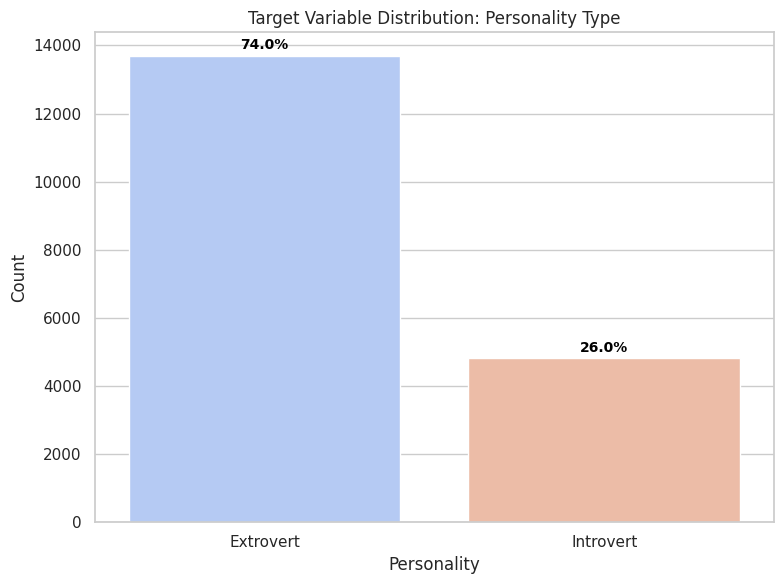

In [26]:
# Countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Personality", data=train, palette="coolwarm")
plt.title("Target Variable Distribution: Personality Type")
plt.xlabel("Personality")
plt.ylabel("Count")

# Compute percentages
total = len(train)
for p in ax.patches:
    count = p.get_height()
    percent = 100 * count / total
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{percent:.1f}%', (x, y + total * 0.01), ha='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


#### 🎯 Target Distribution Analysis

The dataset shows a significant imbalance between the target classes:

- **Extroverts** account for approximately 74% of the data
- **Introverts** make up the remaining 26%

This class imbalance can cause a model to be biased toward the majority class (Extrovert), resulting in high accuracy but poor generalization, especially for detecting Introverts.

### 🛠 Recommended Approaches
To handle this, we will apply one or more of the following strategies:
- Use **Stratified Cross-Validation** to maintain class ratios during training and evaluation
- Apply **class weights** to penalize misclassification of minority class
- Experiment with **SMOTE** (Synthetic Minority Oversampling Technique) to balance the training data

We will also use **metrics beyond accuracy** (like F1-score and confusion matrix) to evaluate model performance fairly.


1.✅ Generate a correlation matrix heatmap (for numeric/ordinal features)

2.✅ Create a pairplot to explore feature interactions and class separation (colored by Personality)



 ## Correlation matrix:

The Personality column is the target variable, and it's categorical (Introvert / Extrovert).
Correlation matrices (like Pearson’s) work only with numerical values, so we can’t compute direct correlations with a string target like 'Introvert'.

🔁 Solution: Convert Personality to Numeric Temporarily
To measure how each feature correlates with the target, you can map:

In [28]:

# Split features by type
categorical_cols = ['Stage_fear', 'Drained_after_socializing']
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                  'Friends_circle_size', 'Post_frequency']

In [29]:
# Encode target column (Extrovert =0, Introvert = 1)
personality_map = {'Extrovert': 0, 'Introvert': 1}
train['Personality'] = train['Personality'].map(personality_map)


In [30]:
# Compute correlation
corr = train.corr(numeric_only=True)


/tmp/ipykernel_463/3709329012.py:5: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


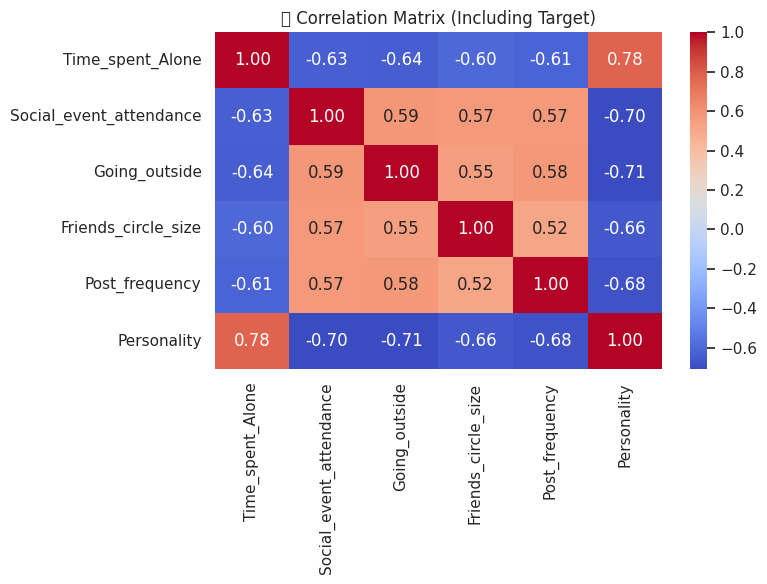

In [31]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('🔗 Correlation Matrix (Including Target)')
plt.tight_layout()
plt.show()


### 🔗 Correlation Insights

❗ Note: You encoded 'Introvert' = 1, 'Extrovert' = 0 →
So:
Positive correlation → linked to Introverts
Negative correlation → linked to Extroverts

The heatmap reveals several important relationships between features and the target:

- **`Time_spent_Alone`** shows a strong **positive correlation** with `Personality` (0.78), indicating that individuals who spend more time alone are more likely to be **Introverts**. This aligns well with common psychological understanding.
  
- **`Social_event_attendance`**, **`Going_outside`**, and **`Post_frequency`** exhibit moderate to strong **negative correlations** with `Personality`(around -0.71 _ -0.66), suggesting that higher levels of social engagement and external activity are associated with **Extroverts**.

These features are likely to be **valuable predictors** in modeling efforts.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

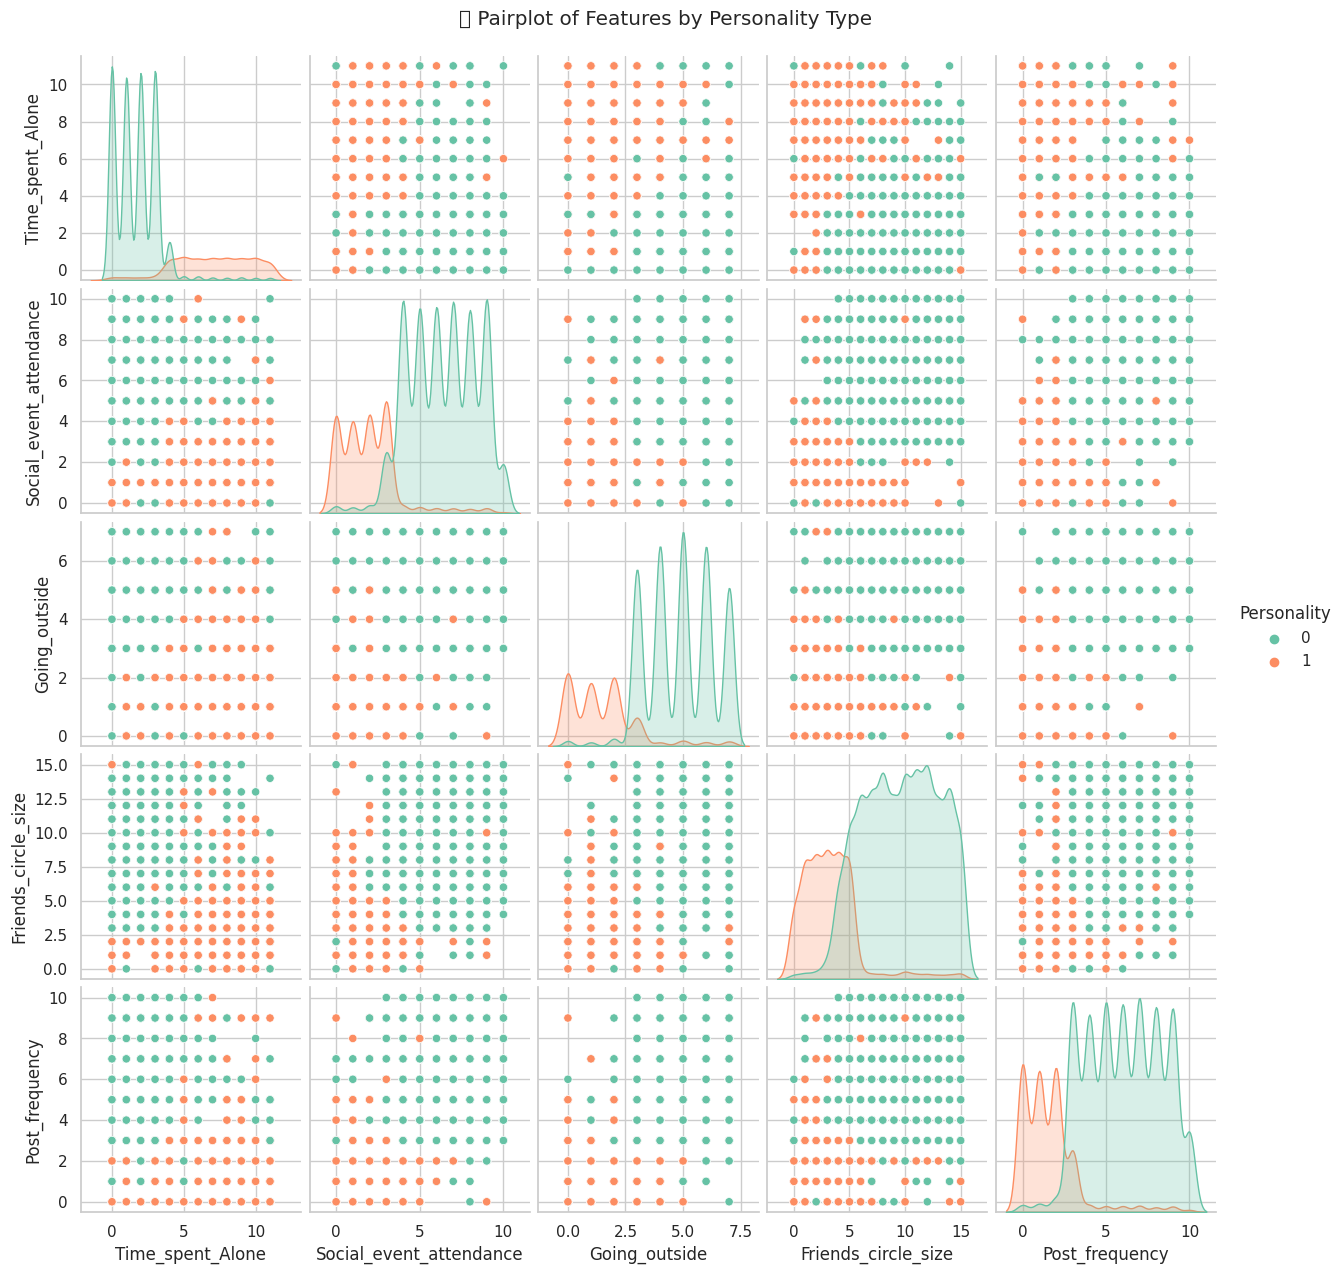

In [33]:
# Create a pairplot with Personality hue
sns.pairplot(train[numeric_features + ['Personality']], hue='Personality', palette='Set2')
plt.suptitle('🧠 Pairplot of Features by Personality Type', y=1.02)
plt.show()


### 🔍 Pairplot Analysis by Personality Type

The pairplot above provides a visual overview of how each pair of numeric features interacts, colored by the target class (`Personality`).

#### 📌 Key Observations:

- **Friends_circle_size vs Post_frequency**: Extroverts (green) tend to have both a **larger social circle** and **higher posting frequency** compared to Introverts (red). These features show **clear class separation**, making them strong candidates for classification.

- **Time_spent_Alone**: Introverts are more concentrated at **higher values**, indicating they spend more time alone, while Extroverts are more spread out or cluster at lower values.

- **Going_outside & Social_event_attendance**: Extroverts are more frequent participants in both activities, as seen in the dense clustering at higher values. Introverts cluster at lower values.

- **Distributions on the diagonals**: These histograms show that:
  - Extroverts dominate high values for `Friends_circle_size`, `Post_frequency`, and `Social_event_attendance`.
  - Introverts are more prevalent at high values of `Time_spent_Alone`.

#### 🧠 Insight:
Several features demonstrate **good class separability**, especially `Friends_circle_size`, `Post_frequency`, and `Social_event_attendance`. This supports the idea that behavioral data can be strong predictors of personality types.

We expect these features to be particularly useful in machine learning models.


# 🧹 3. Preprocessing & Feature Engineering <a name="preprocessing"></a>


### 🧼 Handling Missing Values

Several features in the dataset contain missing values. Rather than dropping these rows, we impute them to preserve data integrity:

- **Numeric features** (e.g., `Time_spent_Alone`, `Post_frequency`) are imputed with the **median** to handle skewed distributions and outliers.
- **Categorical features** (e.g., `Stage_fear`, `Drained_after_socializing`) are imputed with the **most frequent value** (mode), as they typically contain "Yes"/"No" answers.

This approach ensures minimal data loss while maintaining statistical reliability.


In [34]:
# 🔹 2. Handle Missing Values
# ===================================

# Split columns
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency']
cat_cols = ['Stage_fear', 'Drained_after_socializing']

# Fill numeric missing values (use median from train)
for col in num_cols:
    median = train[col].median()
    train[col] = train[col].fillna(median)
    test[col] = test[col].fillna(median)

# Fill categorical missing values (use mode from train)
for col in cat_cols:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    test[col] = test[col].fillna(mode)

In [36]:
# Display unique values for the 'Stage_fear','Drained_after_socializing ,'Personality' columns
print(train['Stage_fear'].unique())
print(train['Drained_after_socializing'].unique())
print(train['Personality'].unique())

['No' 'Yes']
['No' 'Yes']
[0 1]


In [37]:
train.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [38]:
test.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64

In [39]:
train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,0
1,1.0,No,7.0,3.0,No,10.0,8.0,0
2,6.0,Yes,1.0,0.0,No,3.0,0.0,1
3,3.0,No,7.0,3.0,No,11.0,5.0,0
4,1.0,No,4.0,4.0,No,13.0,5.0,0


In [40]:
test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,5.0
1,18525,2.0,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [41]:
print(train[['Stage_fear', 'Drained_after_socializing', 'Personality']].isnull().sum())


Stage_fear                   0
Drained_after_socializing    0
Personality                  0
dtype: int64


In [42]:
print(test[['Stage_fear', 'Drained_after_socializing']].isnull().sum())


Stage_fear                   0
Drained_after_socializing    0
dtype: int64


# Encoding

In [43]:
# 🔸 2. Encode categorical columns ('Yes'/'No' ➜ 1/0)
yes_no_map = {'Yes': 1, 'No': 0}
for col in cat_cols:
    train[col] = train[col].map(yes_no_map)
    test[col] = test[col].map(yes_no_map)
    

In [45]:
print(train[['Stage_fear', 'Drained_after_socializing', 'Personality']].head())
print(train[['Stage_fear', 'Drained_after_socializing', 'Personality']].isnull().sum())  # should be 0


   Stage_fear  Drained_after_socializing  Personality
0           0                          0            0
1           0                          0            0
2           1                          0            1
3           0                          0            0
4           0                          0            0
Stage_fear                   0
Drained_after_socializing    0
Personality                  0
dtype: int64


In [46]:
train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,0,6.0,4.0,0,15.0,5.0,0
1,1.0,0,7.0,3.0,0,10.0,8.0,0
2,6.0,1,1.0,0.0,0,3.0,0.0,1
3,3.0,0,7.0,3.0,0,11.0,5.0,0
4,1.0,0,4.0,4.0,0,13.0,5.0,0


In [47]:
print(test[['Stage_fear', 'Drained_after_socializing']].head())
print(test[['Stage_fear', 'Drained_after_socializing']].isnull().sum())  # should be 0


   Stage_fear  Drained_after_socializing
0           0                          0
1           1                          1
2           0                          0
3           0                          0
4           1                          1
Stage_fear                   0
Drained_after_socializing    0
dtype: int64


In [48]:
test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,0,7.0,4.0,0,6.0,5.0
1,18525,2.0,1,0.0,0.0,1,5.0,1.0
2,18526,3.0,0,5.0,6.0,0,15.0,9.0
3,18527,3.0,0,4.0,4.0,0,5.0,6.0
4,18528,9.0,1,1.0,2.0,1,1.0,1.0


### Countplot of categorical_cols by Personality

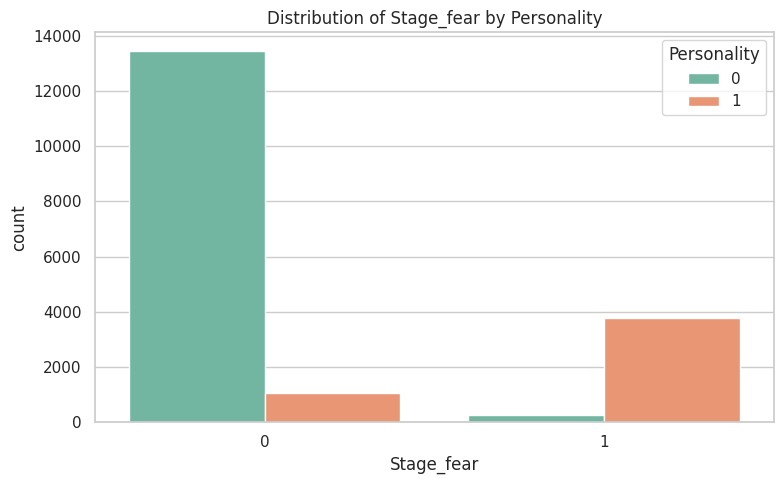

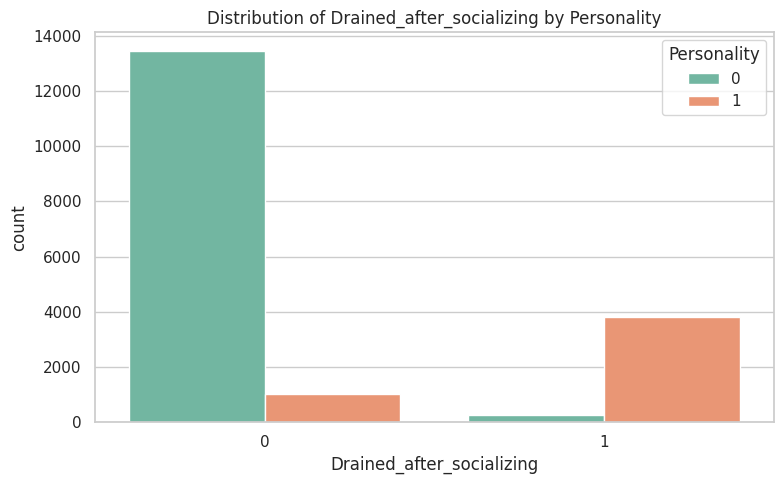

In [49]:


for col in ['Stage_fear', 'Drained_after_socializing']:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(
        x=col,
        data=train,
        hue='Personality',
        palette='Set2'  # or 'pastel', etc.
    )
    plt.title(f"Distribution of {col} by Personality")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


🔸 At this point:
train and test are cleaned

All features are numerical

No missing values

Target is binary and encoded

# 🤖 4. Modeling <a name="modeling"></a>

In [51]:
X = train.drop(columns=['Personality'])  # Drop target # We dropped ID from the beginning  
y = train['Personality']
X_test = test.drop(columns=['id'])


## ⚖️ Handle Class Imbalance

In [52]:
# Calculate class weights (inverse frequency)
extrovert_ratio = (y == 0).mean()
introvert_ratio = (y ==1).mean()

class_weights = [1 / introvert_ratio, 1 / extrovert_ratio]  # [Extrovert, Introvert]


## 🔁 Cross-Validation + CatBoost Training

In [53]:
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n📂 Fold {fold + 1}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='Accuracy',
        class_weights=class_weights,
        random_seed=42,
        verbose=100,
        early_stopping_rounds=50
    )

    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), use_best_model=True)

    # Out-of-fold predictions
    oof_preds[val_idx] = model.predict(X_val_fold)

    # Test predictions (accumulate)
    test_preds += model.predict(X_test) / n_splits



📂 Fold 1
0:	learn: 0.9749661	test: 0.9740594	best: 0.9740594 (0)	total: 53.2ms	remaining: 53.2s
100:	learn: 0.9767408	test: 0.9756053	best: 0.9758340 (53)	total: 567ms	remaining: 5.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9758340238
bestIteration = 53

Shrink model to first 54 iterations.

📂 Fold 2
0:	learn: 0.9747935	test: 0.9746352	best: 0.9746352 (0)	total: 5.74ms	remaining: 5.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9749967201
bestIteration = 4

Shrink model to first 5 iterations.

📂 Fold 3
0:	learn: 0.9752612	test: 0.9726687	best: 0.9726687 (0)	total: 5.18ms	remaining: 5.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9739082988
bestIteration = 4

Shrink model to first 5 iterations.

📂 Fold 4
0:	learn: 0.9741635	test: 0.9772695	best: 0.9772695 (0)	total: 5.1ms	remaining: 5.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9790257179
bestIteration = 28

Shrink model to first

# 📈 5. Evaluation & Interpretation <a name="evaluation"></a>


✅ Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13699
           1       0.95      0.93      0.94      4825

    accuracy                           0.97     18524
   macro avg       0.96      0.96      0.96     18524
weighted avg       0.97      0.97      0.97     18524



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


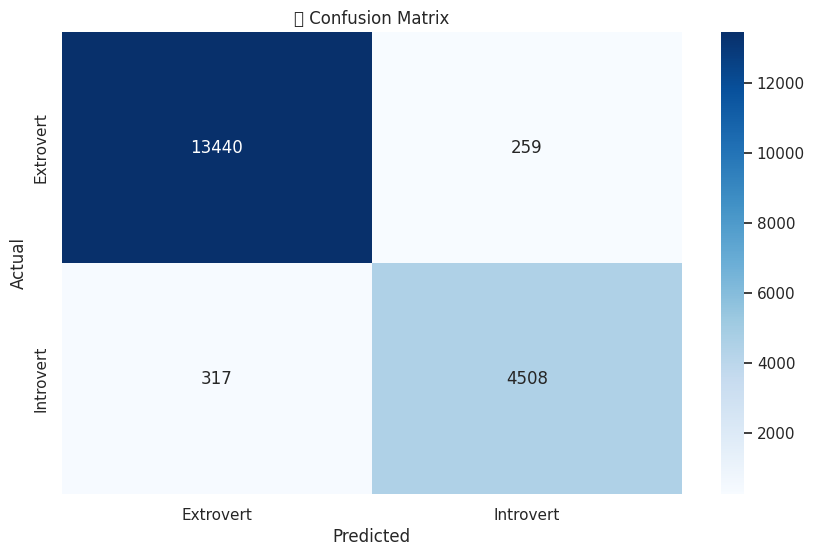

In [54]:
print("\n✅ Classification Report:")
print(classification_report(y, oof_preds.astype(int)))

# Confusion Matrix
cm = confusion_matrix(y, oof_preds.astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Extrovert', 'Introvert'],
            yticklabels=['Extrovert', 'Introvert'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧠 Confusion Matrix")
plt.show()


/tmp/ipykernel_463/1378048361.py:15: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


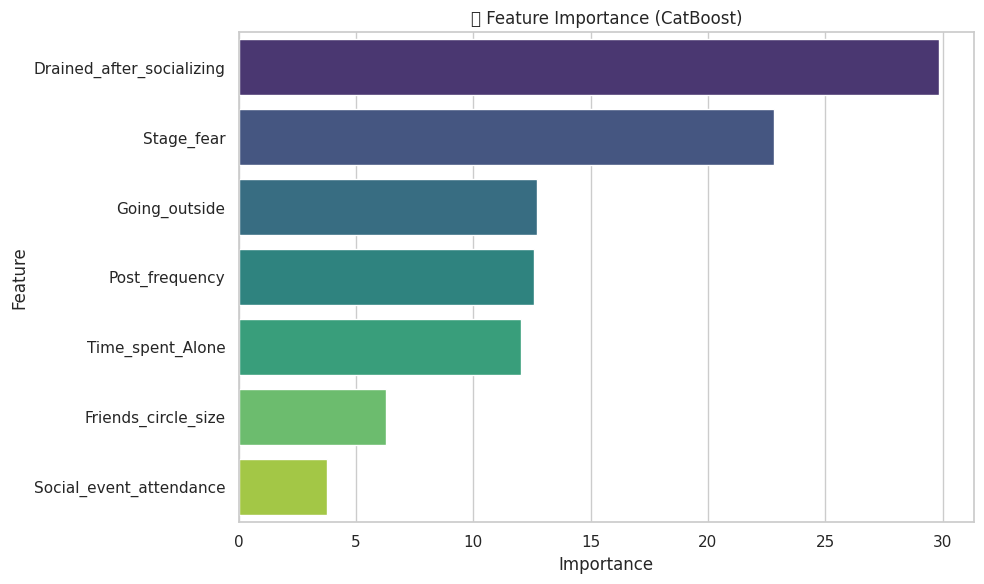

In [55]:
# Get raw importances
importances = model.get_feature_importance()
feature_names = model.feature_names_

# Create DataFrame
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette="viridis")
plt.title("🎯 Feature Importance (CatBoost)")
plt.tight_layout()
plt.show()


# 📝 6. Submission & Conclusion <a name="conclusion"></a>

In [56]:
submission['Personality'] = test_preds.round().astype(int)
submission['Personality'] = submission['Personality'].map({0: 'Extrovert', 1: 'Introvert'})
submission.to_csv("submission.csv", index=False)
submission.head()


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
